In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models

import copy

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Datasets, Transforms and Visualization

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

0it [00:00, ?it/s]

170500096it [00:06, 27119321.30it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
num_classes = 10
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels.shape)
print(labels[1])

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([4])
tensor(0)


In [0]:
def imshow(img, title):
  npimg = img.numpy()/2 + 0.5 ## denormalizing
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [str(x.item()) for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


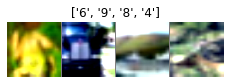

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


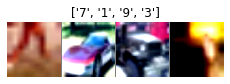

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


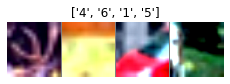

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


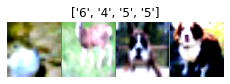

In [0]:
for i in range(4):
  show_batch_images(trainloader)

## Creating VGG-16

In [0]:
from torchvision import models

In [0]:
## 1 Way to change the last layer of classifier to have 10 classes as output
# vgg = models.vgg16_bn(num_classes=num_classes)
# print(vgg)

## Another way to change the last layer of classifier to have 10 classes as output
vgg = models.vgg16_bn()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [0]:
print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [0]:
## changing last layer of classifier to out_features=10, we are using CIFAR 10 dataset
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [0]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Train CIFAR10

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [0]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, pred = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
  print('Accuracy is %f' % (correct/total) )
  return correct/total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.001)

In [0]:
max_epochs = 1
loss_epoch_arr = []

n_iters = np.ceil(50000//batch_size)

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):

    images, labels = data
    images, labels = images.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    del images, labels, outputs
    torch.cuda.empty_cache()

    if i % 100 == 0:
      print('%d/%d Training Loss: %.2f' % (i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())
  print('%d/%d, Training Accuracy: %.2f Test Accuracy: %.2f'%(epoch, max_epochs, evaluation(trainloader, vgg), evaluation(testloader, vgg)))

plt.plot(loss_epoch_arr)
plt.show()

0/3125 Training Loss: 2.44
100/3125 Training Loss: 2.76
200/3125 Training Loss: 2.18
300/3125 Training Loss: 2.02
400/3125 Training Loss: 2.11
500/3125 Training Loss: 2.07
600/3125 Training Loss: 2.18
700/3125 Training Loss: 2.13
800/3125 Training Loss: 2.14
900/3125 Training Loss: 2.17
1000/3125 Training Loss: 1.95
1100/3125 Training Loss: 2.11
1200/3125 Training Loss: 1.95
1300/3125 Training Loss: 2.02
1400/3125 Training Loss: 2.46
1500/3125 Training Loss: 2.00
1600/3125 Training Loss: 1.87
1700/3125 Training Loss: 1.88
1800/3125 Training Loss: 2.12
1900/3125 Training Loss: 1.59
2000/3125 Training Loss: 2.39
2100/3125 Training Loss: 1.90
2200/3125 Training Loss: 1.67
2300/3125 Training Loss: 2.04
2400/3125 Training Loss: 1.90
2500/3125 Training Loss: 1.66
2600/3125 Training Loss: 1.59
2700/3125 Training Loss: 2.14
2800/3125 Training Loss: 1.90
2900/3125 Training Loss: 2.35
3000/3125 Training Loss: 2.03
3100/3125 Training Loss: 1.96


UnboundLocalError: ignored

In [0]:
print(evaluation(trainloader, vgg))
print(evaluation(testloader, vgg))

Accuracy is 0.315580
0.31558
Accuracy is 0.313400
0.3134


## Freeze layers of Convolutional Operations

In [0]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [0]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth

  0%|          | 0.00/528M [00:00<?, ?B/s]
  1%|          | 2.89M/528M [00:00<00:18, 30.3MB/s]
  1%|          | 5.62M/528M [00:00<00:18, 29.3MB/s]
  2%|▏         | 8.38M/528M [00:00<00:18, 29.1MB/s]
  2%|▏         | 11.0M/528M [00:00<00:19, 28.4MB/s]
  3%|▎         | 13.5M/528M [00:00<00:19, 27.4MB/s]
  3%|▎         | 16.1M/528M [00:00<00:19, 27.1MB/s]
  4%|▎         | 18.7M/528M [00:00<00:19, 27.0MB/s]
  4%|▍         | 21.5M/528M [00:00<00:19, 27.7MB/s]
  5%|▍         | 24.2M/528M [00:00<00:19, 27.6MB/s]
  5%|▌         | 26.8M/528M [00:01<00:19, 27.5MB/s]
  6%|▌         | 29.5M/528M [00:01<00:18, 27.7MB/s]
  6%|▌         | 32.2M/528M [00:01<00:18, 28.0MB/s]
  7%|▋         | 34.9M/528M [00:01<00:18, 27.6MB/s]
  7%|▋         | 37.7M/528M [00:01<00:18, 27.9MB/s]
  8%|▊         | 40.3M/528M [00:01<00:18, 27.9MB/s]
  8%|▊         | 43.0M/528M [00:01<00:18, 27.1M

In [0]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
for param in vgg.parameters():
  param.requires_grad = False

In [0]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [0]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.005)

In [0]:
max_epochs = 100
loss_epoch_arr = []

n_iters = np.ceil(50000//batch_size)

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):

    images, labels = data
    images, labels = images.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    del images, labels, outputs
    torch.cuda.empty_cache()

    if i % 100 == 0:
      print('%d: %d/%d Training Loss: %.2f' % (epoch, i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())
  if epoch+1 % 100 == 0:
    print('%d/%d, Training Accuracy: %.2f Test Accuracy: %.2f'%(epoch+1, max_epochs, evaluation(trainloader, vgg), evaluation(testloader, vgg)))

# plt.plot(loss_epoch_arr)
# plt.show()

0/781 Training Loss: 2.30
100/781 Training Loss: 1.80
200/781 Training Loss: 1.60
300/781 Training Loss: 1.76
400/781 Training Loss: 1.47
500/781 Training Loss: 1.58
600/781 Training Loss: 1.40
700/781 Training Loss: 1.34
0/781 Training Loss: 1.59
100/781 Training Loss: 1.41
200/781 Training Loss: 1.22
300/781 Training Loss: 1.26
400/781 Training Loss: 1.31
500/781 Training Loss: 1.51
600/781 Training Loss: 1.25
700/781 Training Loss: 1.42
0/781 Training Loss: 1.36
100/781 Training Loss: 1.25
200/781 Training Loss: 1.43
300/781 Training Loss: 1.36
400/781 Training Loss: 1.33
500/781 Training Loss: 1.31
600/781 Training Loss: 1.22
700/781 Training Loss: 1.22
0/781 Training Loss: 1.41
100/781 Training Loss: 1.26
200/781 Training Loss: 1.51
300/781 Training Loss: 1.29
400/781 Training Loss: 1.09
500/781 Training Loss: 1.60
600/781 Training Loss: 1.26
700/781 Training Loss: 1.25
0/781 Training Loss: 1.37
100/781 Training Loss: 1.48
200/781 Training Loss: 1.10
300/781 Training Loss: 1.32
40

KeyboardInterrupt: ignored

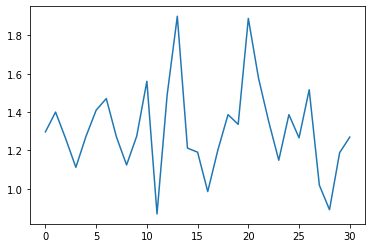

In [0]:
plt.plot(loss_epoch_arr)
plt.show()

## With model copies

In [0]:
import copy

Min Loss is 1.79
0/3125 Training Loss: 1.79
Min Loss is 1.33
Min Loss is 0.97
Min Loss is 0.70
Min Loss is 0.55
100/3125 Training Loss: 1.99
200/3125 Training Loss: 1.76
300/3125 Training Loss: 1.61
400/3125 Training Loss: 2.63
500/3125 Training Loss: 1.74
600/3125 Training Loss: 2.44
700/3125 Training Loss: 2.44
800/3125 Training Loss: 1.86
900/3125 Training Loss: 1.77
1000/3125 Training Loss: 2.68
1100/3125 Training Loss: 1.93
1200/3125 Training Loss: 1.20
1300/3125 Training Loss: 1.32
Min Loss is 0.49
1400/3125 Training Loss: 2.84
1500/3125 Training Loss: 2.55
1600/3125 Training Loss: 2.57
1700/3125 Training Loss: 2.47
1800/3125 Training Loss: 2.70
1900/3125 Training Loss: 1.96
2000/3125 Training Loss: 2.29
2100/3125 Training Loss: 0.93
2200/3125 Training Loss: 3.75
2300/3125 Training Loss: 1.45
2400/3125 Training Loss: 2.20
2500/3125 Training Loss: 2.67
2600/3125 Training Loss: 1.62
2700/3125 Training Loss: 2.49
2800/3125 Training Loss: 1.83
2900/3125 Training Loss: 2.84
3000/3125 

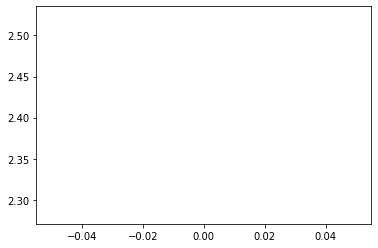

In [0]:
max_epochs = 1
loss_epoch_arr = []

min_loss = 1000

n_iters = np.ceil(50000//batch_size)

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):

    images, labels = data
    images, labels = images.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(vgg.state_dict())
      print('Min Loss is %.2f' % (min_loss))

    del images, labels, outputs
    torch.cuda.empty_cache()

    if i % 100 == 0:
      print('%d/%d Training Loss: %.2f' % (i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())
  print('%d/%d, Training Accuracy: %.2f Test Accuracy: %.2f'%(epoch, max_epochs, evaluation(trainloader, vgg), evaluation(testloader, vgg)))

# plt.plot(loss_epoch_arr)
# plt.show()

In [0]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

Accuracy is 0.426620
Accuracy is 0.425200
0.42662 0.4252


## ResNet Model

In [0]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [0]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, pred = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
  print('Accuracy is %f' % (correct/total) )
  return correct/total

In [0]:
resnet = models.resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet.parameters():
  param.requires_grad = False

# for param in resnet.layer1.parameters():
#   param.requires_grad = True
for param in resnet.layer2.parameters():
  param.requires_grad = True
for param in resnet.layer3.parameters():
  param.requires_grad = True
for param in resnet.layer4.parameters():
  param.requires_grad = True

In [0]:
in_features = resnet.fc.in_features
# resnet.fc = nn.Linear(in_features, num_classes)

resnet.fc = nn.Sequential(
    nn.BatchNorm1d(in_features),
    nn.Linear(in_features, 200),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.BatchNorm1d(200),
    nn.Linear(200, num_classes)
)

In [0]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Siz

In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
# opt = optim.SGD(resnet.parameters(), lr=0.005, weight_decay=4e-3)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0/781, Min Loss is 0.31
Epoch: 1 0/781 Training Loss: 0.31
3/781, Min Loss is 0.15
16/781, Min Loss is 0.14
46/781, Min Loss is 0.13
Epoch: 1 100/781 Training Loss: 0.29
112/781, Min Loss is 0.13
120/781, Min Loss is 0.13
156/781, Min Loss is 0.11
Epoch: 1 200/781 Training Loss: 0.28
222/781, Min Loss is 0.07
Epoch: 1 300/781 Training Loss: 0.12
Epoch: 1 400/781 Training Loss: 0.15
Epoch: 1 500/781 Training Loss: 0.38
Epoch: 1 600/781 Training Loss: 0.29
Epoch: 1 700/781 Training Loss: 0.24
Epoch: 2 0/781 Training Loss: 0.27
Epoch: 2 100/781 Training Loss: 0.15
Epoch: 2 200/781 Training Loss: 0.40
Epoch: 2 300/781 Training Loss: 0.29
Epoch: 2 400/781 Training Loss: 0.18
Epoch: 2 500/781 Training Loss: 0.32
Epoch: 2 600/781 Training Loss: 0.39
Epoch: 2 700/781 Training Loss: 0.31
Epoch: 3 0/781 Training Loss: 0.32
Epoch: 3 100/781 Training Loss: 0.34
Epoch: 3 200/781 Training Loss: 0.24
Epoch: 3 300/781 Training Loss: 0.24
Epoch: 3 400/781 Training Loss: 0.21
Epoch: 3 500/781 Training L

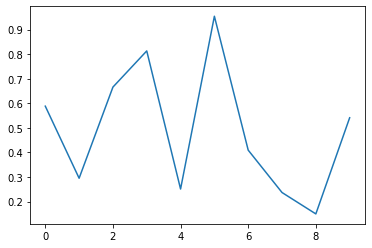

CPU times: user 19min 14s, sys: 5min 7s, total: 24min 22s
Wall time: 24min 23s


In [0]:
%%time

# opt = optim.Adam([{"params": resnet.fc.parameters(), "lr": 0.001},
#                   {"params": resnet.layer2.parameters(), "lr": 1e-5},
#                   {"params": resnet.layer3.parameters(), "lr": 1e-4},
#                   {"params": resnet.layer4.parameters(), "lr": 1e-4}], lr=0.001)#, weight_decay=4e-3)
opt = optim.SGD([{"params": resnet.fc.parameters(), "lr": 0.00001},
                 {"params": resnet.layer2.parameters(), "lr": 1e-7},
                  {"params": resnet.layer3.parameters(), "lr": 1e-6},
                  {"params": resnet.layer4.parameters(), "lr": 1e-6}], lr=0.001)#, weight_decay=4e-3)
# opt = optim.SGD(resnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)

max_epochs = 10
loss_epoch_arr = []

min_loss = 1000

n_iters = np.ceil(50000//batch_size)

for epoch in range(max_epochs):
  scheduler.step()
  for i, data in enumerate(trainloader, 0):

    images, labels = data
    images, labels = images.to(device), labels.to(device)

    opt.zero_grad()

    outputs = resnet(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(resnet.state_dict())
      print('%d/%d, Min Loss is %.2f' % (i, n_iters, min_loss))

    del images, labels, outputs
    torch.cuda.empty_cache()

    if i % 100 == 0:
      print('Epoch: %d %d/%d Training Loss: %.2f' % (epoch+1, i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())
  # if epoch+1 % 10 == 0:
  #   print('%d/%d, Training Accuracy: %.2f Test Accuracy: %.2f'%(epoch+1, max_epochs, evaluation(trainloader, resnet), evaluation(testloader, resnet)))

print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

plt.plot(loss_epoch_arr)
plt.show()

In [0]:
%%time
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

Accuracy is 0.856320
Accuracy is 0.830600
0.85632 0.8306
CPU times: user 2min 8s, sys: 16.7 s, total: 2min 25s
Wall time: 2min 25s


In [0]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

Accuracy is 0.899400
Accuracy is 0.857000
0.8994 0.857


In [0]:
torch.save(resnet.state_dict(), './resnet_weights')
# the_model.load_state_dict(torch.load('./resnet_weights'))

In [0]:
!ls -alh resnet_weights

-rw-r--r-- 1 root root 44M Jan 15 14:08 resnet_weights


## Inception v3 Model

In [0]:
inception = models.inception_v3(pretrained=True)
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
for param in inception.parameters():
  param.requires_grad = False

In [0]:
in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(in_features, num_classes)

In [0]:
for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [0]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [0]:
for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.05)

In [0]:
def evaluation_inception(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs, aux_outputs = model(images)
    _, pred = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
  print('Accuracy is %f' % (correct/total) )
  return 100 * correct/total

In [0]:
max_epochs = 1
loss_epoch_arr = []

min_loss = 1000

n_iters = np.ceil(50000//batch_size)

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):

    images, labels = data
    images, labels = images.to(device), labels.to(device)

    opt.zero_grad()

    outputs, aux_outputs = inception(images)
    loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(inception.state_dict())
      print('Min Loss is %.2f' % (min_loss))

    del images, labels, outputs
    torch.cuda.empty_cache()

    if i % 100 == 0:
      print('%d/%d Training Loss: %.2f' % (i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())
  print('%d/%d, Training Accuracy: %.2f Test Accuracy: %.2f'%(epoch, max_epochs, evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception)))

# plt.plot(loss_epoch_arr)
# plt.show()

Min Loss is 2.77
0/3125 Training Loss: 2.77
Min Loss is 1.43
Min Loss is 0.95
100/3125 Training Loss: 1.82
200/3125 Training Loss: 1.53
300/3125 Training Loss: 2.13
400/3125 Training Loss: 2.77
500/3125 Training Loss: 2.44
600/3125 Training Loss: 3.23
700/3125 Training Loss: 1.71
800/3125 Training Loss: 2.42
900/3125 Training Loss: 1.75
1000/3125 Training Loss: 3.22
1100/3125 Training Loss: 2.23
1200/3125 Training Loss: 2.29
1300/3125 Training Loss: 1.64
1400/3125 Training Loss: 2.38
1500/3125 Training Loss: 2.68
1600/3125 Training Loss: 1.96
1700/3125 Training Loss: 2.26
1800/3125 Training Loss: 1.75
1900/3125 Training Loss: 2.99
2000/3125 Training Loss: 1.64
2100/3125 Training Loss: 1.99
2200/3125 Training Loss: 1.79
2300/3125 Training Loss: 2.56
2400/3125 Training Loss: 2.05
2500/3125 Training Loss: 1.48
2600/3125 Training Loss: 2.10
2700/3125 Training Loss: 3.32
2800/3125 Training Loss: 2.52
2900/3125 Training Loss: 2.01
3000/3125 Training Loss: 1.99
3100/3125 Training Loss: 2.95
A

In [0]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

Accuracy is 0.431740
Accuracy is 0.434100
0.43174 0.4341


## Exercises
1. Structure the above code into a series of functions and then call each model - Not very important
2. Tune the models and get best published results on them
3. Try CIFAR100, STL10 datasets
4. Try SqueezeNet - Read the paper
5. Try training multiple layers and not just the last layer